In [1]:
%matplotlib inline
%matplotlib notebook 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.io.img_tiles as cimgt
from haversine import haversine
from IPython.display import Audio,display
import seaborn as sns
from ipywidgets import *
from copy import deepcopy

In [2]:
# Reading Earthquake Data
array_vals = pd.read_csv("/data_tohoku_norm_transpose.csv", header=None)
v = pd.date_range("2:46PM", "6:46PM", freq="1s")
v -= v[0]
array_vals["time"] = v
array_vals.set_index("time", inplace=True)

In [3]:
# Reading Locations Data
locations = pd.read_csv("/location.txt",
                        delimiter="\t", names =["longitude", "latitude", "a", "b"])
del locations["a"], locations["b"]

In [4]:
# Calculating Distance using haversine and reindexing based on distance
origin_lat = 38.322 
origin_long = 142.369
locations['distance'] = locations.apply(lambda x: haversine((x['latitude'],x['longitude']),(origin_lat,origin_long)),axis=1)
dist_array_vals = array_vals.reindex_axis(locations.sort_values(by=['distance']).index,axis=1)
spec_array_vals = np.log(dist_array_vals.transpose()**2)

In [5]:
# Creating labels for Map
display_locations = locations.round(2)
display_array_vals = array_vals.round(4)
generated_labels = ["Lat:{0}, Long:{1}, Mag:{2}".format(display_locations['longitude'][i],display_locations['latitude'][i],display_array_vals[i]['00:00:00']) for i in range(0, len(locations))]



/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


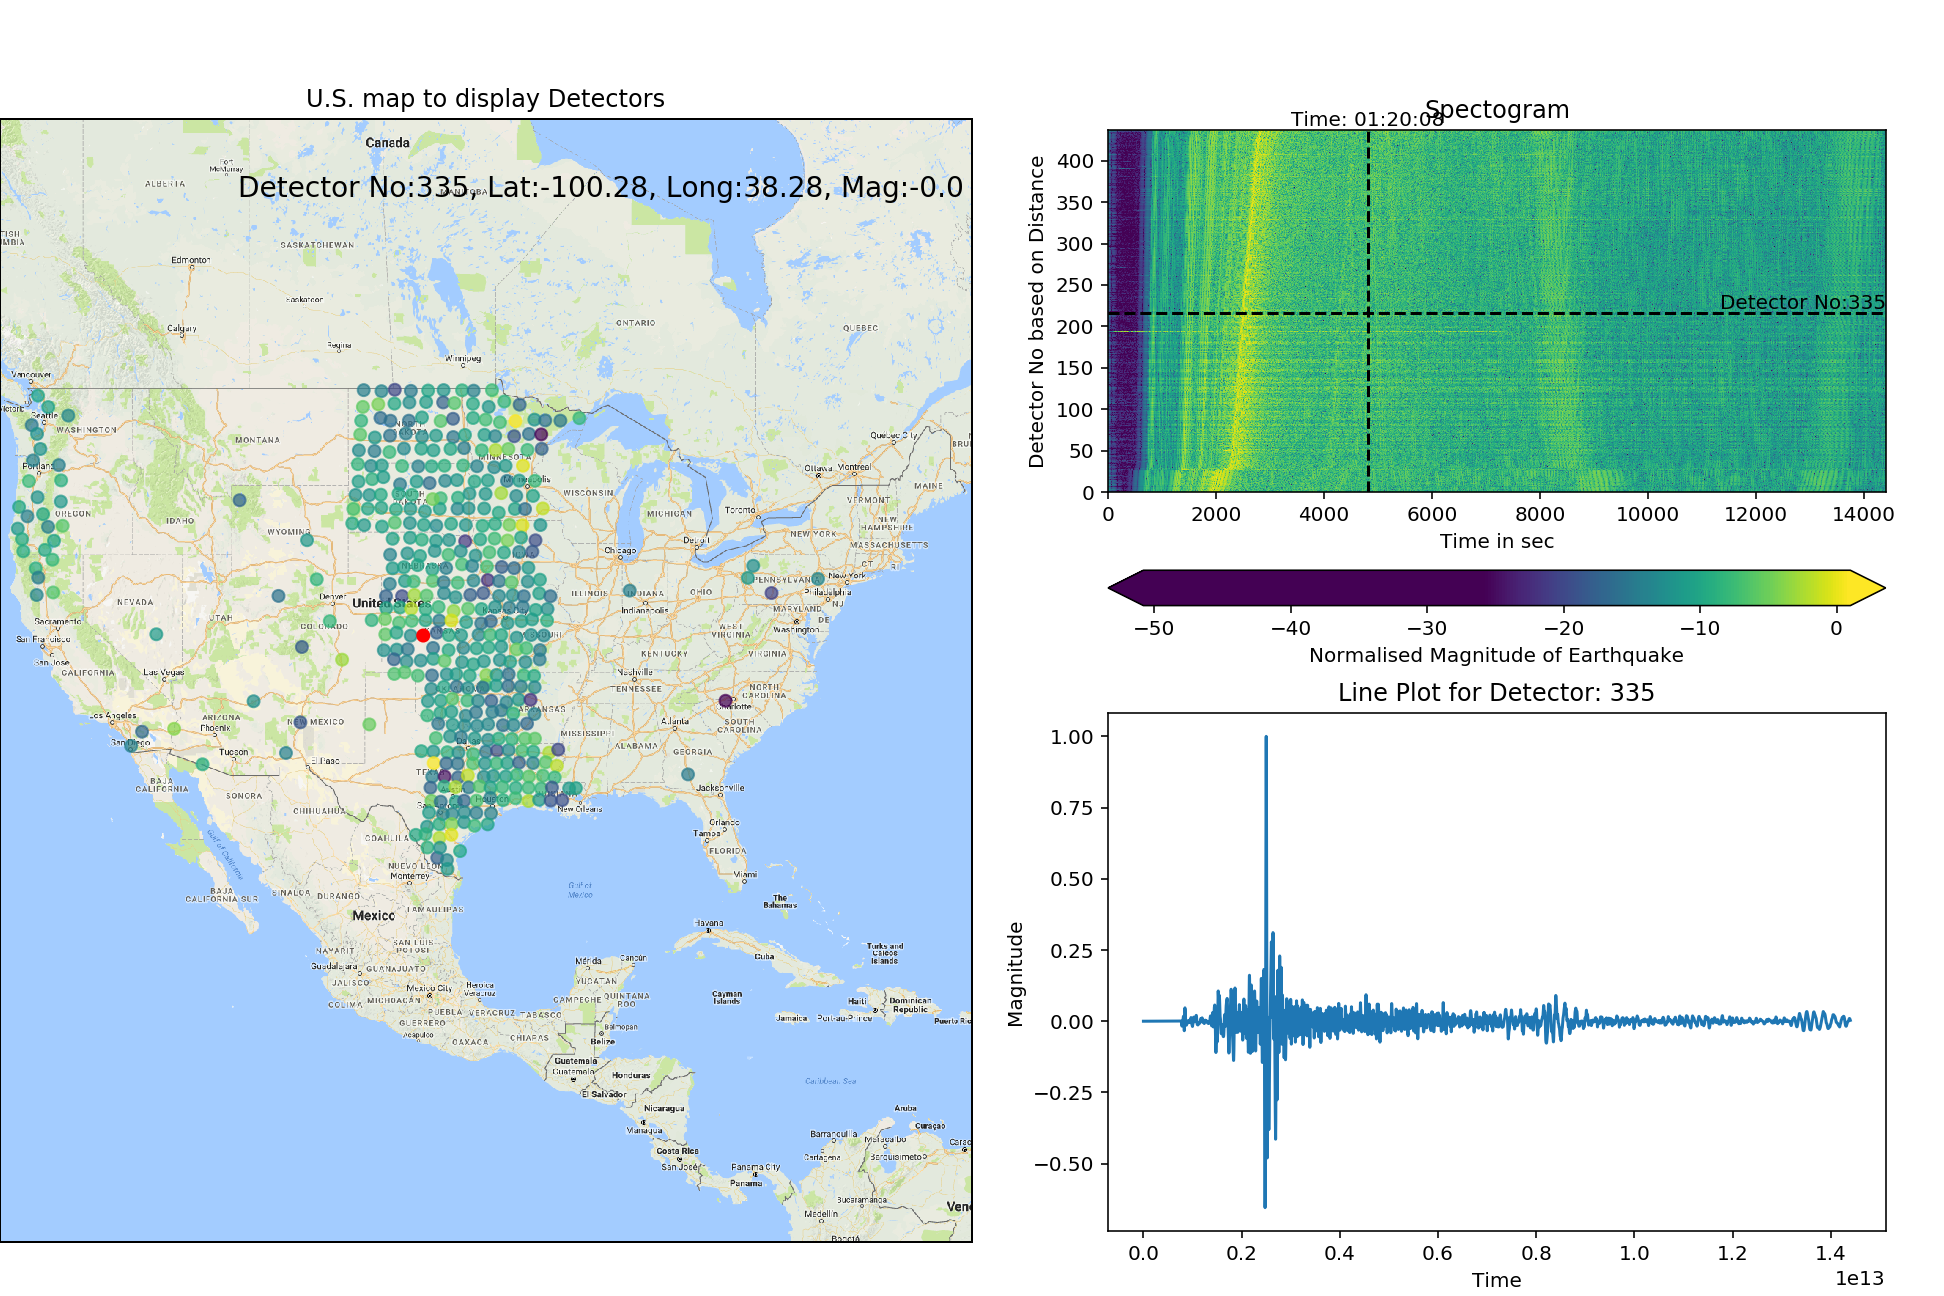

A Jupyter Widget

<function __main__.time_change>

In [9]:
# Creating figure and axis for map
fig = plt.figure(figsize=(13.5,9))
ax1 = fig.add_axes([0,0.025,0.5,0.9], projection = cartopy.crs.GOOGLE_MERCATOR)
ax1.set_extent([-125, -66.5, 5, 55], cartopy.crs.Geodetic())
ax1.add_image(cimgt.GoogleTiles(),5)
ax1.set_title('U.S. map to display Detectors')
ax3 = fig.add_axes([0.57,0.05,0.4,0.4])
ax2 = fig.add_axes([0.57,0.5,0.4,0.4])
ax2.set_title('Spectogram')
ax2.set_xlabel('Time in sec')
ax2.set_ylabel('Detector No based on Distance')
im = ax2.imshow(spec_array_vals,aspect='auto',cmap='viridis')
cb = fig.colorbar(im,orientation='horizontal',extend='both')
cb.set_clim(spec_array_vals[spec_array_vals != -np.inf].min().min()+25, spec_array_vals.max().max())
cb.set_label('Normalised Magnitude of Earthquake')
ax2.invert_yaxis()
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()

# Creating Global variables
sctr = None 
prev_point_color = None
prev_point_ind = None
detector_line = None
detector_text = None
time_line = None
time_text = None
txt = None
def intialise():
    """ Method to intialise values on the first load of the map"""
    global detector_text
    global detector_line
    global txt
    global generated_labels
    ax3.plot(array_vals[0])
    ax3.set_title('Line Plot for Detector: 0')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Magnitude')
    detector_line = plt.axhline(spec_array_vals.index.get_loc(0), linestyle='--',color='black')
    detector_text = plt.text(x1, spec_array_vals.index.get_loc(0), "Detector No:"+str(0), ha='right', va='bottom')
    txt = ax1.text(-67, 56, "Detector No:"+str(0)+", "+generated_labels[0],horizontalalignment='right',transform=cartopy.crs.Geodetic(),size=14)




def onclick2(event):
    """ Changing marker color, line plot and xline on spectogram"""
    global sctr
    global detector_line
    global detector_text
    global prev_point_color
    global prev_point_ind
    global txt
    global generated_labels
    if prev_point_ind is not None:
        sctr._facecolors[prev_point_ind,:] = deepcopy(prev_point_color)
    prev_point_color = deepcopy(sctr._facecolors[event.ind[0],:])
    prev_point_ind = event.ind[0]
    sctr._facecolors[event.ind[0],:] = (1, 0, 0, 1)
    ax3.clear()
    ax3.set_title('Line Plot for Detector: '+str(event.ind[0]))
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Magnitude')
    ax3.plot(array_vals[event.ind[0]])
    if detector_line is not None:
        detector_line.remove()
    if detector_text is not None:
        detector_text.remove()
    detector_line = plt.axhline(spec_array_vals.index.get_loc(event.ind[0]), linestyle='--',color='black')
    detector_text = plt.text(x1, spec_array_vals.index.get_loc(event.ind[0]), "Detector No:"+str(event.ind[0]), ha='right', va='bottom')
    txt.remove()
    txt = ax1.text(-67, 56, "Detector No:"+str(event.ind[0])+", "+generated_labels[event.ind[0]],horizontalalignment='right',transform=cartopy.crs.Geodetic(), size=14)
    fig.canvas.draw_idle()

# Binding event
fig.canvas.mpl_connect('pick_event', onclick2)

def time_change(n):
    """ Changing scatter color on the map based on time and moving yline on spectogram"""
    global sctr
    global time_line
    global time_text
    global prev_point_color
    global prev_point_ind
    callIntialise = False
    if sctr is not None:
        sctr.remove()
    else:
        callIntialise = True
    sctr = ax1.scatter(locations["longitude"], locations["latitude"], transform = cartopy.crs.Geodetic(),picker=1,
          c=array_vals.iloc[n], alpha=0.7, cmap="viridis") 
    if time_line is not None:
        time_line.remove()
    if time_text is not None:
        time_text.remove()
    time_line = plt.axvline(n, linestyle='--', color='black')
    time_text = plt.text(n, y1,'Time: '+str(array_vals.index[n])[-8:], ha='center', va='bottom')
    if callIntialise:
        intialise()
        callIntialise = False

        
interact(time_change, n = IntSlider(value=0,min=0,max=14400,description='Time in sec',continuous_update=False,readout=True))

In [18]:
normed = (array_vals[0] - array_vals[0].min())/(array_vals[0].max() - array_vals[0].min()) * 2 - 1
display(Audio(np.sin(2*np.pi*array_vals[0]), rate=44100/8))